In [161]:
import json, sys, random
import numpy as np
import pandas as pd
import tensorflow as tf

In [162]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD



In [163]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

In [164]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
path = "/content/drive/MyDrive/shipsnet.json"
with open(path, "r") as f:
    dataset = json.load(f)


In [166]:
# Turning the json information into a numpy array and then assign it as our X and y values

X = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [167]:

pd.Series(y).value_counts()

,count
0,3000
1,1000


In [168]:
# Identifying the class names
class_names = ['Not A Ship', 'Ship']  #0 for not ship , 1 for ship

In [169]:
X.shape

(4000, 19200)

In [170]:
X_reshaped = X.reshape([-1, 3, 80, 80])              # بنقسم الداتا ل 3 طبقات

X_reshaped.shape

(4000, 3, 80, 80)

In [171]:
# get one chanel
pic = X_reshaped[3]    #الصورة رقم 4 في الداتا

Red_Channel = pic[0]
Green_Channel = pic[1]
Blue_Channel = pic[2]

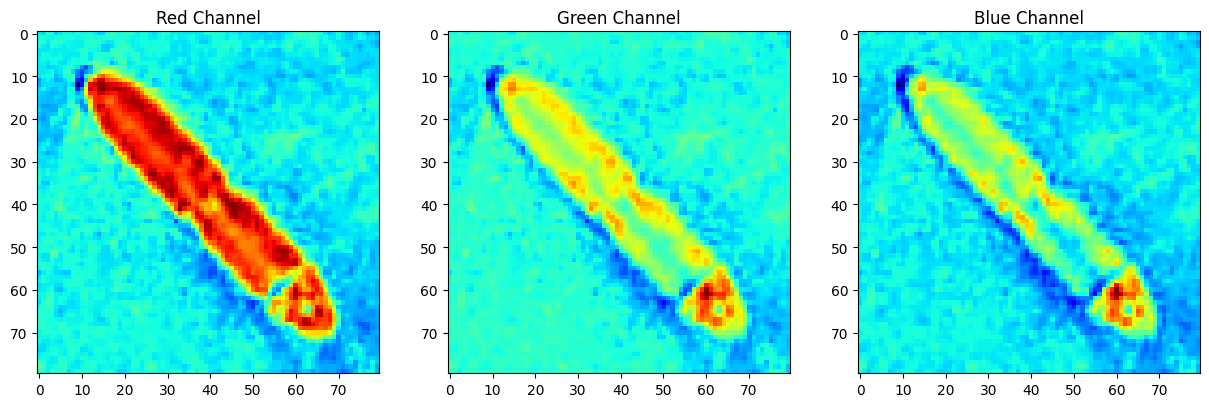

In [172]:
plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')

# getting each channel
plt.subplot(1, 3, 1)
plt.imshow(Red_Channel)
plt.title("Red Channel")

plt.subplot(1, 3, 2)
plt.imshow(Green_Channel)
plt.title("Green Channel")

plt.subplot(1, 3, 3)
plt.imshow(Blue_Channel)
plt.title("Blue Channel")

plt.show()

In [173]:
X_reshaped = X.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
X_reshaped.shape

(4000, 80, 80, 3)

In [174]:
y_reshaped = tf.keras.utils.to_categorical(y, num_classes=2)

y_reshaped.shape

(4000, 2)

In [175]:
imgs_0 = X_reshaped[y==0]    #هات من X_reshaped كل الصور اللي مكانها True في الـ mask
imgs_1 = X_reshaped[y==1]   #بياخد كل الصور اللي label بتاعها = 1

In [176]:
def plot(a,b):

    plt.figure(figsize=(15, 15))
    plt.subplot(2,4,1)
    plt.title('Not A Ship')
    plt.imshow(a[0])
    plt.subplot(2,4,2)
    plt.title('Not A Ship')
    plt.imshow(a[1])
    plt.subplot(2,4,3)
    plt.title('Not A Ship')
    plt.imshow(a[2])
    plt.subplot(2,4,4)
    plt.title('Not A Ship')
    plt.imshow(a[3])
    plt.subplot(2,4,5)
    plt.title('Ship')
    plt.imshow(b[0])
    plt.subplot(2,4,6)
    plt.title('Ship')
    plt.imshow(b[1])
    plt.subplot(2,4,7)
    plt.title('Ship')
    plt.imshow(b[2])
    plt.subplot(2,4,8)
    plt.title('Ship')
    plt.imshow(b[3])
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.25)

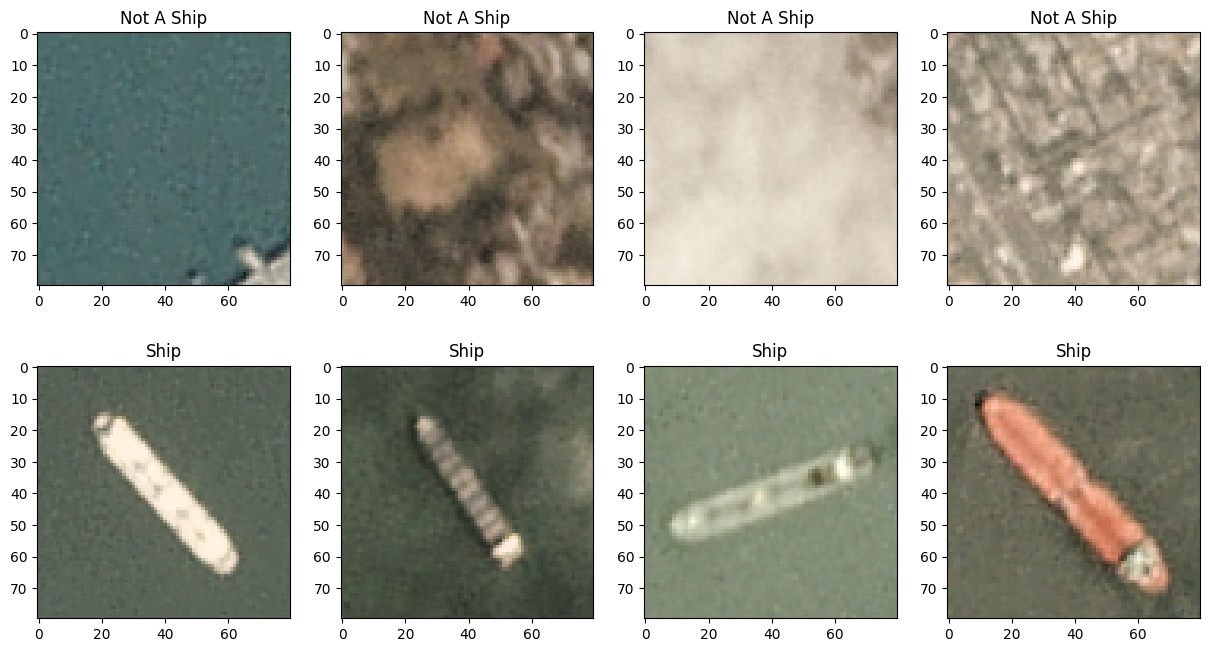

In [177]:
plot(imgs_0, imgs_1)

In [178]:
# Normalizing the X values

X_reshaped = X_reshaped / 255         #حوّل قيم الـ pixels من [0 → 255] إلى [0 → 1]

In [179]:
# Doing the initial train/test split on the reshaped values

X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.20, random_state=42)

# Creating the validation set

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [180]:
np.random.seed(42)

In [181]:
# network design
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())

# fully con
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [182]:
# optimization setup
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

In [183]:
# training
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=2)

Epoch 1/20
75/75 - 32s - 430ms/step - accuracy: 0.8217 - loss: 0.4095 - val_accuracy: 0.9125 - val_loss: 0.2546
Epoch 2/20
75/75 - 40s - 530ms/step - accuracy: 0.9025 - loss: 0.2287 - val_accuracy: 0.9287 - val_loss: 0.2297
Epoch 3/20
75/75 - 41s - 540ms/step - accuracy: 0.9087 - loss: 0.2035 - val_accuracy: 0.9362 - val_loss: 0.1780
Epoch 4/20
75/75 - 41s - 544ms/step - accuracy: 0.9200 - loss: 0.1927 - val_accuracy: 0.9488 - val_loss: 0.1507
Epoch 5/20
75/75 - 29s - 391ms/step - accuracy: 0.9337 - loss: 0.1698 - val_accuracy: 0.9500 - val_loss: 0.1332
Epoch 6/20
75/75 - 32s - 425ms/step - accuracy: 0.9467 - loss: 0.1320 - val_accuracy: 0.9563 - val_loss: 0.1128
Epoch 7/20
75/75 - 29s - 382ms/step - accuracy: 0.9550 - loss: 0.1189 - val_accuracy: 0.9500 - val_loss: 0.1260
Epoch 8/20
75/75 - 41s - 548ms/step - accuracy: 0.9638 - loss: 0.0915 - val_accuracy: 0.9575 - val_loss: 0.1090
Epoch 9/20
75/75 - 29s - 382ms/step - accuracy: 0.9638 - loss: 0.0830 - val_accuracy: 0.9500 - val_loss:

In [184]:
# Finding our final accuracy on the test set

model.evaluate(X_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9806 - loss: 0.0966


[0.09715311974287033, 0.9750000238418579]

In [185]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 40, 40, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 10, 10, 32)     │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       410,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,065,926 (4.07 MB)

 Trainable params: 532,962 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 532,964 (2.03 MB)

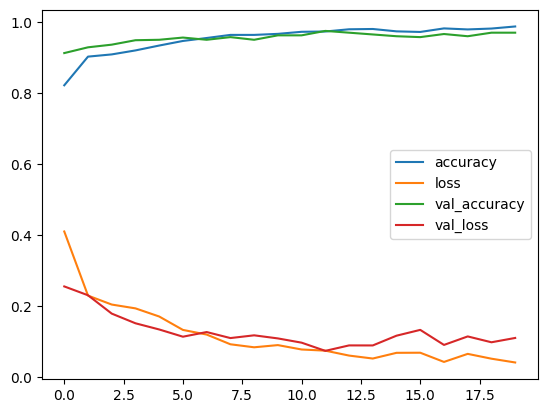

In [186]:
# Plotting the loss and accuracy

pd.DataFrame(history.history).plot();

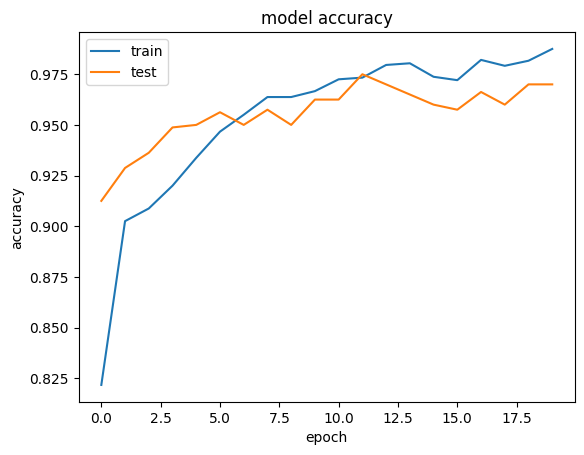

In [187]:
# View model training accuracy graph.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

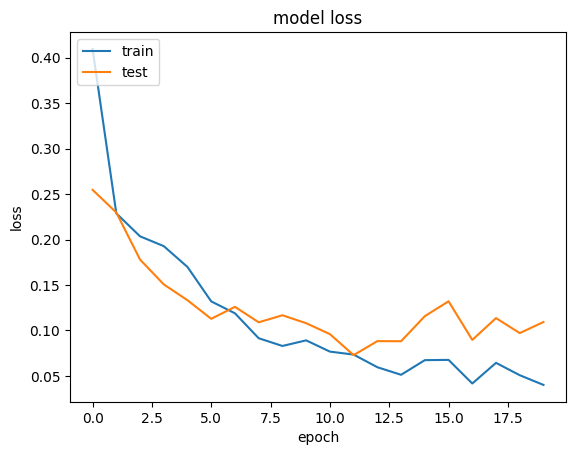

In [188]:
# View model training loss graph.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [189]:
y_pred = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


In [190]:
y_pred = (y_pred > 0.5)

In [191]:
from sklearn.metrics import classification_report,accuracy_score

# print("Accuracy: "+str(accuracy_score(y_train, y_pred)))
# print('\n')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       591
           1       0.97      0.93      0.95       209

   micro avg       0.97      0.97      0.97       800
   macro avg       0.97      0.96      0.97       800
weighted avg       0.97      0.97      0.97       800
 samples avg       0.97      0.97      0.97       800



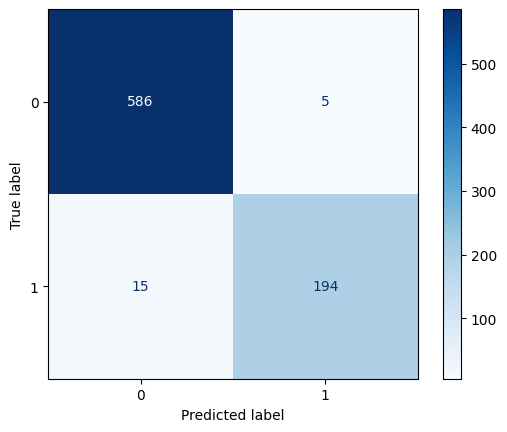

In [192]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = y_test.argmax(axis=1)
y_pred_cls = y_pred.argmax(axis=1)

labels = [0, 1]
cm = confusion_matrix(y_true, y_pred_cls, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.show()

In [194]:
from PIL import Image

image = Image.open(
    '/content/drive/MyDrive/sample input.png'
)

pix = image.load()


In [195]:
n_spectrum = 3
width = image.size[0]
height = image.size[1]

In [196]:
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

In [197]:
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)

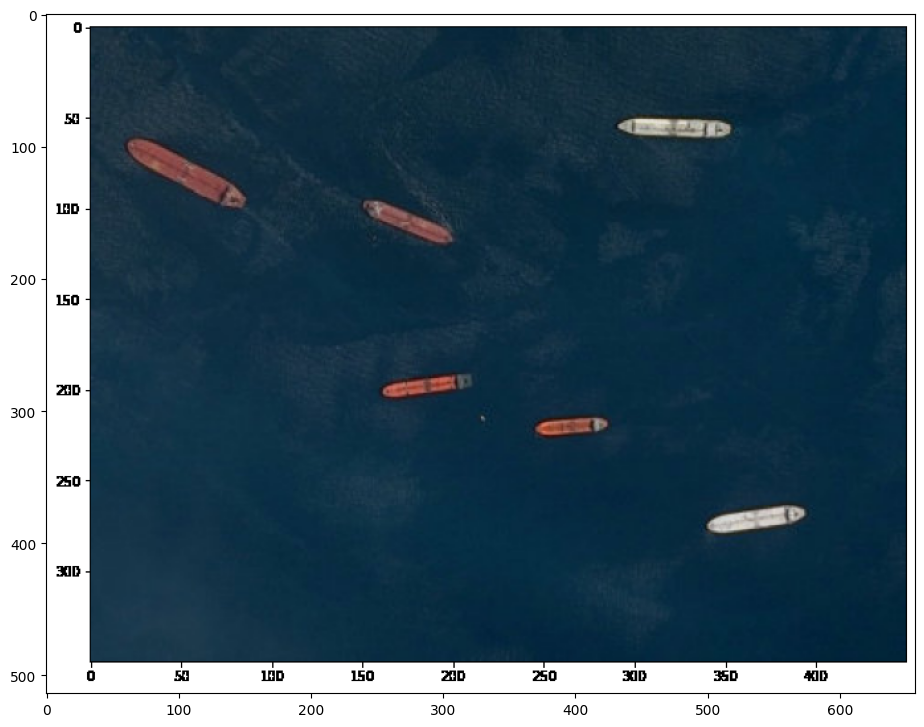

In [198]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()


In [199]:
picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor.shape

(3, 514, 657)

In [200]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [201]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [202]:
def show_ship(x, y, acc, thickness=3):
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

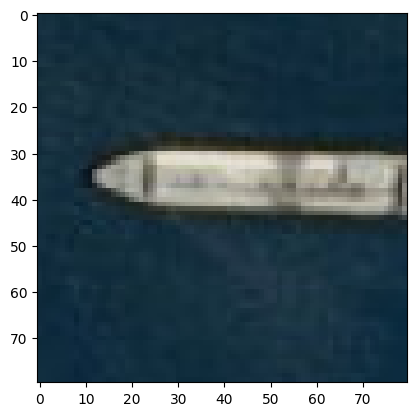

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

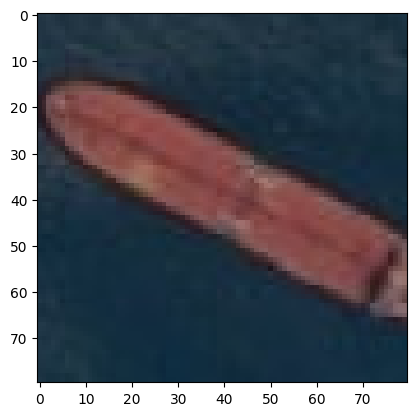

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

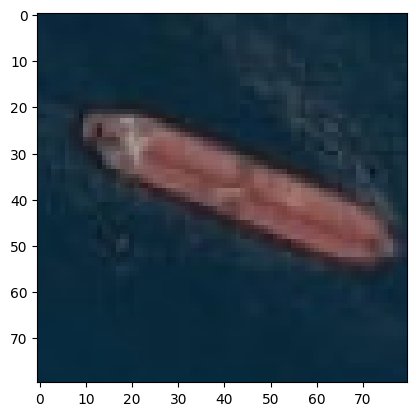

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━

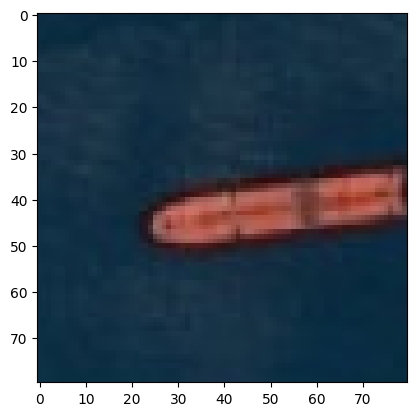

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

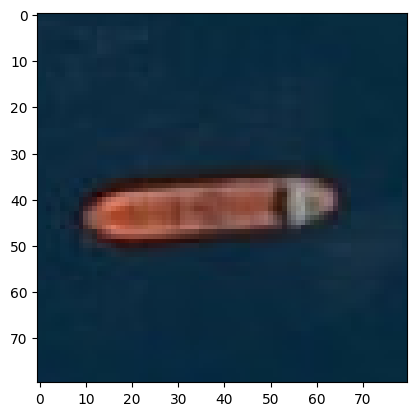

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

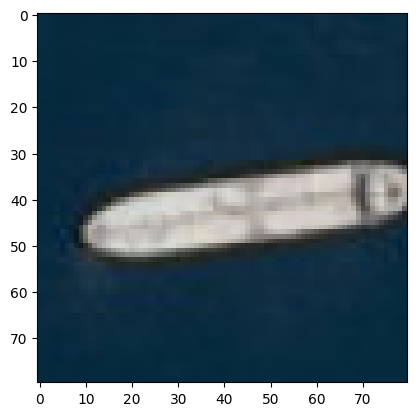

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

In [203]:
step = 10
coordinates = []
counter=0
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            print(++counter)
            plt.imshow(area[0])
            plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Example coordinate: [[420, 50], array([[0.00256597, 0.9974341 ]], dtype=float32)]


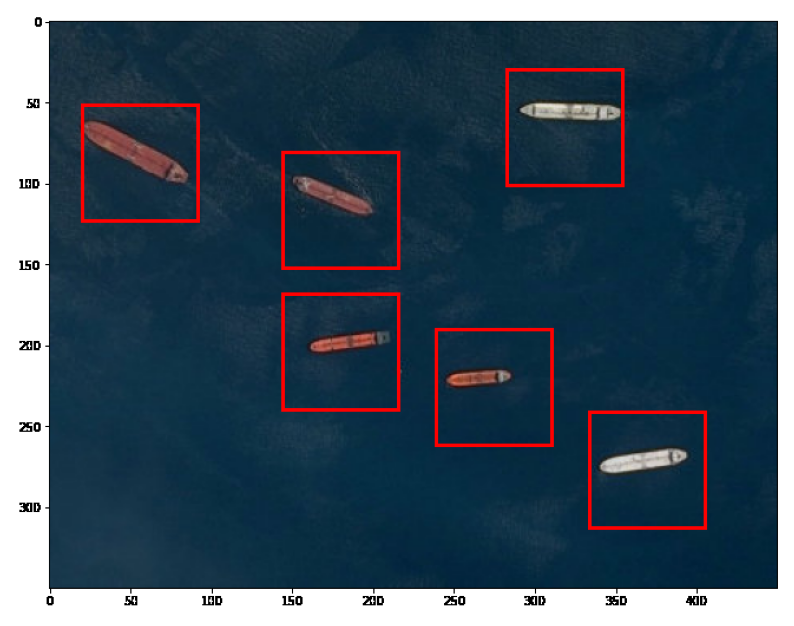

Saved: /content/drive/MyDrive/ship_boxes.png


In [204]:

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

img_path = "/content/drive/MyDrive/sample input.png"
img = np.array(Image.open(img_path).convert("RGB"))  # (H,W,3) uint8

# =========================
# 3) Helper: parse coordinates robustly
# =========================
def parse_box(e, default_size=150):

    # Case 1: flat list/tuple of 4 numbers
    if isinstance(e, (list, tuple)) and len(e) == 4 and all(isinstance(v, (int, float, np.integer, np.floating)) for v in e):
        x, y, w, h = e
        return int(x), int(y), int(w), int(h)

    # Case 2: ((x,y),(w,h)) or ((x,y),(w,h),acc)
    if isinstance(e, (list, tuple)) and len(e) >= 2:
        a, b = e[0], e[1]

        # a should be (x,y)
        if isinstance(a, (list, tuple)) and len(a) >= 2:
            x, y = a[0], a[1]
        else:
            raise ValueError(f"Can't parse x,y from: {e}")

        # b may be (w,h) OR something nested
        w = h = None
        if isinstance(b, (list, tuple)):
            # try to find two numbers inside b
            nums = []
            def collect_nums(obj):
                if isinstance(obj, (int, float, np.integer, np.floating)):
                    nums.append(obj)
                elif isinstance(obj, (list, tuple)):
                    for t in obj:
                        collect_nums(t)
            collect_nums(b)
            if len(nums) >= 2:
                w, h = nums[0], nums[1]

        if w is None or h is None:
            w = h = default_size

        return int(x), int(y), int(w), int(h)

    raise ValueError(f"Unknown coordinate format: {e}")

# =========================
# 4) Draw rectangles
# =========================
def draw_boxes(img, coordinates, thickness=2, color=(255, 0, 0), default_size=80):
    """
    img: (H,W,3) uint8
    coordinates: list of boxes in different formats
    """
    out = img.copy()
    H, W = out.shape[:2]

    for e in coordinates:
        x, y, w, h = parse_box(e, default_size=default_size)

        # Clip to image bounds
        x0 = max(0, x)
        y0 = max(0, y)
        x1 = min(W - 1, x + w)
        y1 = min(H - 1, y + h)

        if x0 >= x1 or y0 >= y1:
            continue

        # Draw border with slicing
        t = max(1, int(thickness))
        # top
        out[y0:y0+t, x0:x1+1] = color
        # bottom
        out[max(y1-t+1, 0):y1+1, x0:x1+1] = color
        # left
        out[y0:y1+1, x0:x0+t] = color
        # right
        out[y0:y1+1, max(x1-t+1, 0):x1+1] = color

    return out


print("Example coordinate:", coordinates[0])

img_boxed = draw_boxes(
    img,
    coordinates,
    thickness=3,
    color=(255, 0, 0),   # أحمر
    default_size=100
)

plt.figure(figsize=(10, 10))
plt.imshow(img_boxed)
plt.axis("off")
plt.show()

# Save output
out_path = "/content/drive/MyDrive/ship_boxes.png"
Image.fromarray(img_boxed).save(out_path)
print("Saved:", out_path)


In [205]:
# Putting all of the predictions in a dataFrame

df = pd.DataFrame(y_pred, columns=class_names)

df = df.round(6)

df

,Not A Ship,Ship
0,False,True
1,True,False
2,False,True
3,True,False
4,True,False
...,...,...
795,True,False
796,False,True
797,True,False
798,True,False


In [206]:
df['Test is a Ship'] = y_test[:, 1]

df

,Not A Ship,Ship,Test is a Ship
0,False,True,1.0
1,True,False,0.0
2,False,True,1.0
3,True,False,0.0
4,True,False,0.0
...,...,...,...
795,True,False,0.0
796,False,True,1.0
797,True,False,0.0
798,True,False,0.0


In [207]:
df['Difference'] = df['Ship'] - df['Test is a Ship']

df.sort_values('Difference', ascending=True).head(10)

,Not A Ship,Ship,Test is a Ship,Difference
650,True,False,1.0,-1.0
651,True,False,1.0,-1.0
617,True,False,1.0,-1.0
578,True,False,1.0,-1.0
560,True,False,1.0,-1.0
537,True,False,1.0,-1.0
518,True,False,1.0,-1.0
472,True,False,1.0,-1.0
376,True,False,1.0,-1.0
365,True,False,1.0,-1.0
